Code from Gavin (?): lebohec.c

Comment in there:
Code for calculating analytical Cerenkov images. They can be compared to real or MC examples as per LeBohec etal 1999.
Image energy, impact parameter, and direction origin can be derived using this method.

Taken from 
- Hillas (1982) J. Phys. G: Nucl. Phys. 8, 1461
- Hillas (1982b) J. Phys. G: Nucl. Phys. 8, 1475
- LeBohec et.al. (1999)  Nucl. Inst. Meth. A 416, 425
- Kertzmann & Sembroski (1994) Nucl. Inst. Meth. A 343, 629 

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import root_scalar
import seaborn as sns
from scipy.stats import rv_continuous
from scipy.integrate import quad, simpson
from copy import copy, deepcopy
from ipywidgets import interact
from astropy.coordinates import Angle
from src.omega_calculator import OmegaCalculator

In [2]:
CRITICAL_ENERGY = 80 * u.MeV # From Hillas 1982 Page 6
ELECTRON_REST_MASS = 0.511 * u.MeV # Rest mass energy of electron
RADIATION_LENGTH = 36.2 * u.g * u.cm**(-2) # Distance which an electron loses 1/e of its energy by bremsstrahlung
X_0 = 1030.0 * u.g / (u.cm**2) # Thickness of atmosphere
LIGHT_SPEED = 299792458.0 * u.m / u.s
# HEIGHT_INTERVAL = 1000*u.m # May need to copy this out 

In [3]:
@u.quantity_input(height=u.km)
# Calculates "Depth" when given a certain height
# Depth = 0, corresponds to top of atmosphere7
def convert_height_to_depth(height):
    '''
    Inverse of parameterisation given by Gaisser pg. 34.
    Parameters
    ----------
    height: Quantity
        Height of the shower to be considered.
            
    Returns
    -------
    depth: Quantity
        Height converted to depth.
    '''
    
    if np.shape(height) == ():
        if height <= 11.008*u.km:
            depth = ((44.34*u.km - height) / (11.861*u.km) ) ** 5.263

        elif (height > 11.008*u.km) and (height <= 25.090*u.km):
            depth = np.exp((45.5*u.km - height) / (6.34*u.km) )
    else:
        depth = np.full(len(height), np.nan)
        mask = height <= 11.008*u.km
        depth[mask] = ((44.34*u.km - height[mask]) / (11.861*u.km) ) ** 5.263
        
        mask = (height > 11.008*u.km) & (height <= 25.090*u.km)
        depth[mask] = np.exp((45.5*u.km - height[mask]) / (6.34*u.km) )

    return depth * u.g / u.cm**2

@u.quantity_input(height=u.km)
# Calculates Refractive Index when given a certain height. 
# Refractive index changes due to atmosphere changing at different heights
def calc_refractive_index(height):
    '''Calculates the refractive index at a given height.
    Parameters
    ----------
    height: Quantity
        Height in the atmosphere where the refractive index should be caclulated.
        
    Returns
    -------
    refractive_index: Quantity
        Refractive index.
    '''
    depth = convert_height_to_depth(height)
    refrac_index = (1.0 + (0.000296 * depth * 273.2 * u.g * u.cm**(-2) / (X_0 * (204.0 * u.g / u.cm**2 + 0.091 * depth))))
    return refrac_index

Hillas 1982
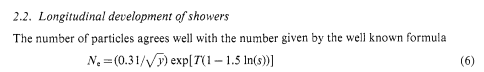
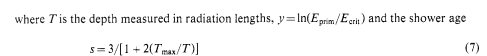

In [4]:
# Main purpose is to simulate air shower, where you can calculate the number of particles and age of shower at a given height
# Based on primary energy of particle
class ExtensiveAirShower:
    
    @u.quantity_input(energy_primary=u.GeV, height=u.km)
    def __init__(self, energy_primary, height=0*u.km):
        '''Class to create an extensive air shower, 
        initiated by a gamma ray of a specific energy.
        Parameters
        ----------
        energy_primary: Quantity
            Energy of primary incident gamma ray
        '''
        self.energy_primary = energy_primary
        self.height = height
        self.number_particles = self.calc_number_shower_particles(height)
        self.shower_age = self.calc_shower_age(height)

    # Manually update the height, and # of particles and shower age will correspondingly update
    @u.quantity_input(height=u.km)
    def update_height(self, height):
        self.height = height
        self.number_particles = self.calc_number_shower_particles(height)
        self.shower_age = self.calc_shower_age(height)

    @u.quantity_input(height=u.km)
    def calc_number_shower_particles(self, height):
        '''Greisen formula (Hillas 1982 eq 6) to estimate total number of shower
        particles at a given height.
        Parameters
        ----------
        height: Quantity
            Height of the shower for which the number of particles is to be calculated.
        
        Returns
        -------
        n_particles: int
            Number of particles at given height.
        '''
        depth = convert_height_to_depth(height)
        shower_age = self.convert_depth_to_shower_age(depth)
        
        y = np.log(self.energy_primary / CRITICAL_ENERGY)
        
        # depth measured in radiation lengths
        T = 2 * y / (( 3 / shower_age) - 1)
        n_particles = ( 0.31 / np.sqrt(y) 
                       * np.exp(T * (1 - 1.5 * np.log(shower_age) ) ) )
        return int(n_particles)
    
    
    @u.quantity_input(depth=u.g/u.cm**2)
    def convert_depth_to_shower_age(self, depth):
        '''Shower age for photon-induced showers.
        From Hillas (1982), Eq. (7).
        Parameters
        ----------
        depth: Quantity
            Depth of shower.
        Returns
        -------
        shower_age: Quantity
            Shower age or shower size. 
        '''
        T = depth / RADIATION_LENGTH
        
        # Only for photon-induced showers:
        Tmax = np.log(self.energy_primary / CRITICAL_ENERGY)
        
        s = ( 3.0 / 
             (1.0 + 2.0 * ( Tmax / T) ) )
        return s
    
    @u.quantity_input(height=u.km)
    def calc_shower_age(self, height):
        '''Calculates the shower age / size at a given height.
        Parameters
        ----------
        height: Quantity
            Height in the atmosphere where the shower age should be caclulated.
        
        Returns
        -------
        shower_age: Quantity
            Shower age.
        '''
        depth = convert_height_to_depth(height)
        shower_age = self.convert_depth_to_shower_age(depth)
        return shower_age.value

In [5]:
# define new class for random generator
# Defining pdf in order to integrate over bounds to get cdf

# Inherits from rv_continous, allows us to use .rvs() to drawn random samples from distribution
class rand_gen_energy(rv_continuous):
    '''Random generator to create sample following integral energy distribution
        from shower size-dependent empirical law given by Hillas (1982) eq. 8'''

    # Takes shower age and optional lower bound of electron energy
    def __init__(self, shower_age, a=np.log10(ELECTRON_REST_MASS.to(u.MeV).value)):
        super().__init__(a=a)

        self.norm = 1
        # Normalisation computed by numerically integrating _pdf from lower bound self.a to 10
        # Total probability (area under pdf) is 1
        self.norm = quad(lambda x: self._pdf(x, shower_age), self.a, 10)[0]

    # Defines the PDF (f is T(E)), self.norm calculated in initialization with given bounds
    def _pdf(self, x, shower_age):
        E = 10**x
        if (shower_age >= 0.4):
            E0 = 44.0 - 17.0 * (shower_age - 1.46) ** 2
        else:
            E0 = 26.0

        f = ( (0.89 * E0 - 1.2)/(E0 + E) ) ** shower_age * (1 + 1e-4 * shower_age * E) ** (-2)
        s1 = shower_age / (E0 + E)
        s2 = 2e-4 * shower_age * (1 + 1e-4 * shower_age * E) ** -1
        return (-f * ( s1 + s2)) / self.norm

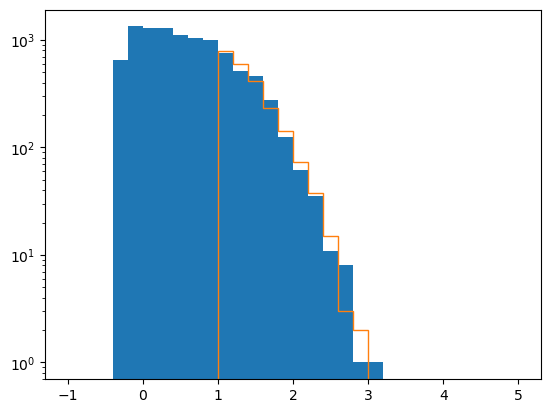

In [6]:
# Defining shower age and number of samples from random dist
s = 1.2
n = 10000

# Initialize rand_gen class
rg = rand_gen_energy(s)
# fraction is Fraction of distribution with energies below 10MeV
fraction = rg._cdf(np.log10(10), s)

# Generates n random energy samples from full energy distribution, plotted over (-1,5) with 30 bins
plt.hist(rg.rvs(s, size=n), range=(-1,5), bins=30, density=False)

# Initialize new rand_gen class but with lower bound, a = 1, corresponds to log10(10) (Energies from 10MeV)
rg = rand_gen_energy(s, a=1)

# Samples drawn is n * (1-fraction), fraction of events with energies above 10MeV
plt.hist(rg.rvs(s, size=int(n*(1-fraction))), range=(-1,5), bins=30, density=False, histtype='step')

plt.yscale('log')

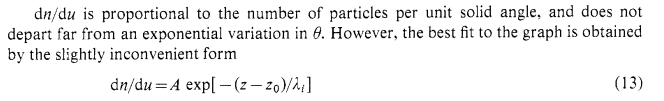

In [7]:
# define new class for random generator
# Primary purpose is to generate random angular values for different energy regimes according to exponential distribution
# Simulates spread of secondary particles or equilavently angular distribution of cherenkov light produced
class rand_gen_angle(rv_continuous):
    '''Random generator to create sample following '''

    def __init__(self, below_50MeV=True):
        # Let's define it in range 5 MeV to 10 GeV (for normalisation etc).
        # Energy ranges etc need to be in log to avoid numerical problems
        super().__init__(a=-3, b=1)

        self.below_50MeV = below_50MeV

        # Calculate integral to normalise distribution to achieve PDF
        self.norm = 1
        xs = np.linspace(self.a, self.b, 10000)
        ys = self._pdf(xs)
        self.norm = 1 / np.sum(np.diff(xs) * ys[:-1])

    # Define the angle PDF
    def _pdf(self, u):
        z = np.atleast_1d(np.sqrt(10**u))
        lbd = np.empty(len(z))

        if self.below_50MeV:
            z0 = 0.59
            A = 0.777
            lbd[z<=z0] = 0.478
            lbd[z>z0] = 0.38
        else:    
            z0 = 0.37
            A = 1.318
            lbd[z<=z0] = 0.413
            lbd[z>z0] = 0.38

        return self.norm * A * np.exp(-(z-z0)/lbd)

Minimum energy
$E_{min} = \sqrt{\frac{m_e^2}{1-\frac{1}{n^2}}}$
Comes from cherenkov condition

$\beta>\frac{1}{n}$ ($\beta = \frac{v}{c}$)

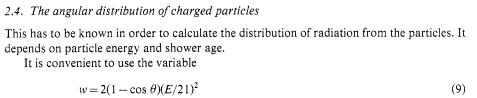 (this is rearranged to get theta instead of w)

In [8]:
# This class is an individual charged particle within the shower
class ShowerParticle:
    '''Class to describe a charged particle within the shower.
    '''
    
    def __init__(self, air_shower):
        self.height = air_shower.height
        self.shower_age = air_shower.shower_age
        self.number_particles = air_shower.number_particles

    # Assigns the particle its properties, energy, angle, position and velocity factor (beta)
    # remove_nonCherenkov just removes any particles without enough energy to produce cherenkov radiation
    def sample(self, remove_nonCherenkov=True):
        self.sample_energy(remove_nonCherenkov)
        self.sample_angle()
        self.sample_position()
        self.calc_beta()
    
    # uses rand_gen_energy to sample from energy distribution
    def sample_energy(self, remove_nonCherenkov=True):
        n = calc_refractive_index(self.height)
        # calculate minimum energy the electron must have to produce Cherenkov photons
        # using beta > 1/n
        Emin = np.sqrt(ELECTRON_REST_MASS**2 / (1 - 1/n**2))
        xmin = np.log10(Emin.to(u.MeV).value)
        
        rg = rand_gen_energy(shower_age=self.shower_age)
        
        if remove_nonCherenkov:
            # fraction of particles below Emin
            fraction = rg._cdf(xmin, self.shower_age)
            rg = rand_gen_energy(shower_age=self.shower_age, a=xmin)
        else:
            fraction = 0
            
        self.energy = 10**rg.rvs(self.shower_age, size=int((1-fraction)*self.number_particles)) * u.MeV
    
    # Uses rand_gen_angle to sample the angular deviation of particle from shower axis
    def sample_angle(self):
        rg_LE = rand_gen_angle(below_50MeV=True)
        rg_HE = rand_gen_angle(below_50MeV=False)
        mask = self.energy < 50 * u.MeV
        w_norm = np.zeros(len(self.energy))
        w_norm[mask] = 10**rg_LE.rvs(size=np.sum(mask))
        w_norm[~mask] = 10**rg_HE.rvs(size=np.sum(~mask))
        self.w_norm = w_norm
        
        # Equation in appendix A of Lebohec (1998):
        w_mean = 0.9 / (1.0 + (120.0 / self.energy.to(u.MeV).value))
        
        w = w_norm * w_mean
        self.w = w
        
        # Theta: Deviation angle from shower axis:
        # Eq.9 Hillas (1982):
        self.theta = np.arccos(1.0 - ( (self.energy / (21.0*u.MeV)) ** (-2) * w / 2.0) )

        
    @u.quantity_input(E=u.eV)  
    # Returns probability density of given energy valye
    def get_energy_distribution(self, E):
        '''
        Sample particle energy from shower size-dependent empirical law given
         by Hillas (1982) eq. 8
         Parameters
        ----------
        E: Quantity
            Kinetic energy in MeV
        
        Returns
        -------
        
         '''
        x = np.log10(E.to(u.MeV).value)
        return 10**rand_gen_energy(shower_age=self.shower_age)._pdf(x)
    
    # Determines position of particle in coordinate system aligned with its motion
    def sample_position(self):
        '''Returns position of particle in coords aligned to particle motion 
        such that y-axis displacement = 0. Don't forget to convert from gcm^-2 to metres,
        using 'gh'.'''
        self.x = ( (2.05 + 2.56 * self.shower_age ** 2) 
                  * (self.energy.to(u.MeV).value - 7.0) ** 0.25 
                  * np.sqrt(self.w) 
                  * (21.0*u.MeV/self.energy) ) * u.g * u.cm**(-2)
        self.y = 0.0 * u.g * u.cm**(-2)
        
        sy = ( 21.0*u.MeV/self.energy 
                   * np.log(1.0 + self.energy/(6*u.MeV) ) 
                   * np.exp(0.1 * np.log(self.w) - 0.633 + self.shower_age/0.56))
        sx = sy * (1.0 + 0.64 * np.sqrt(self.w))
        
        self.x = self.x + np.random.normal(0, sx) * u.g / u.cm**2
        self.y = np.random.normal(0, sy)  * u.g / u.cm**2

        gh = 20*u.m / (convert_height_to_depth(self.height - 10*u.m) - convert_height_to_depth(self.height + 10*u.m))
        self.x *= gh
        self.y *= gh
        
    # Calculates particle's speed as fraction of light (beta)
    def calc_beta(self):
        self.beta = np.sqrt( self.energy.to(u.MeV)**2 - ELECTRON_REST_MASS**2 ) / self.energy

In [9]:
# Setting energy of primary particle and height
e_prim = 10*u.TeV
height = 5 * u.km

# With a primary energy of 10TeV at 5km, s is 1.17 and there are 8438 particles
eas = ExtensiveAirShower(e_prim, height)
print(eas.number_particles)
print(eas.shower_age)

8438
1.1790786037164087


In [10]:
%%time 
# Generates energy distribution of particles in shower at 5km altitude for 10TeV primary particle
p = ShowerParticle(eas)
p.sample()
print(len(p.energy))

699
CPU times: user 2.82 s, sys: 39 ms, total: 2.86 s
Wall time: 2.91 s


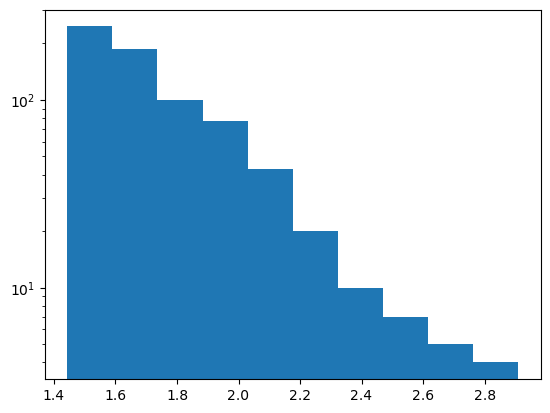

In [11]:
# Plots energy values in log scale
plt.hist(np.log10(p.energy.value))
plt.yscale('log')

## Shower Characteristics

- Height vs. number of particles
- Height vs. shower size
- Height vs. refractive index

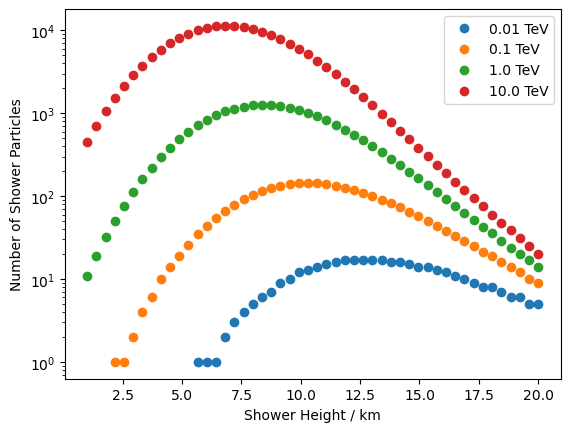

In [12]:
# Creates logspace of energies and linspace of heights
energies = np.logspace(1,4,4)*u.GeV
heights = np.linspace(1,20,50)*u.km

# Determines how many shower particles are at each height of the shower

# Gamma ray enters atmosphere and intiiates cascade of secondary particles
# Initially small number of high energy electrons and positrons are produced
# These high energy particles produce further generations so it increases rapidly
# Each generation has less energy than the previous
# Eventually average energy is too low that cascane cant effectively continue multiplying
for energy in energies:
    eas = ExtensiveAirShower(energy)

    number_particles = []

    for height in heights:
        eas.update_height(height)
        number_particles += [eas.number_particles]

    plt.plot(heights, number_particles, 'o', label=eas.energy_primary.to(u.TeV))

plt.xlabel('Shower Height / km')
plt.ylabel('Number of Shower Particles')
plt.yscale('log')
plt.legend()
plt.show()

# Height = 0 when at ground, Height = 20km when at primary particle entrance
# Depth = 0 at primary particle entrance, increases as particles travel further downwards

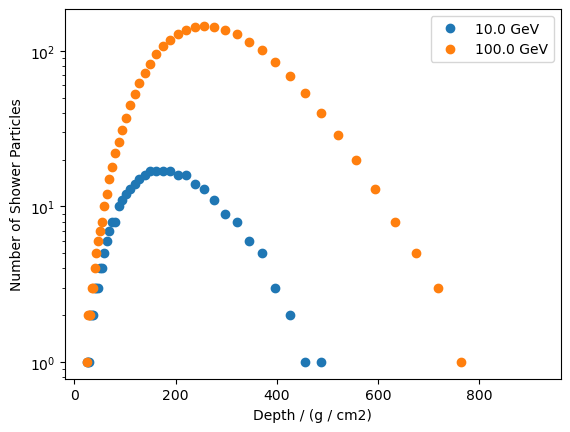

In [13]:
energies = np.array([10, 100])*u.GeV
heights = np.linspace(1,25,50)*u.km
depths = convert_height_to_depth(heights)

for energy in energies:
    eas = ExtensiveAirShower(energy)

    number_particles = []

    for height in heights:
        eas.update_height(height)
        number_particles += [eas.number_particles]

    plt.plot(depths, number_particles, 'o', label=eas.energy_primary.to(u.GeV))

plt.xlabel('Depth / (g / cm2)')
plt.ylabel('Number of Shower Particles')
plt.yscale('log')
plt.legend()
plt.show()

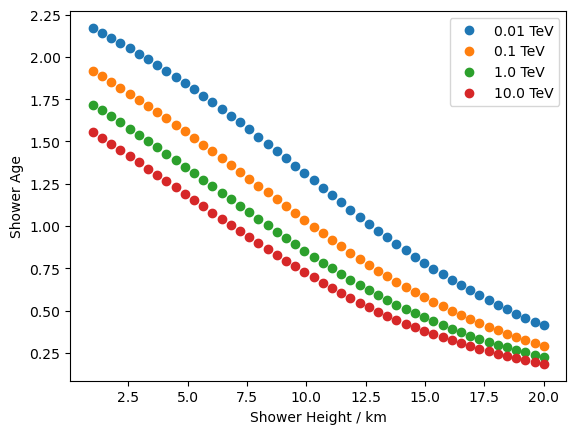

In [14]:
energies = np.logspace(1,4,4)*u.GeV
heights = np.linspace(1,20,50)*u.km

# Shower enters atmosphere 20km up and at s = 0
# Particles seem to be moving faster intiially, and slow down over time likely due to atmospheres
for energy in energies:
    eas = ExtensiveAirShower(energy)

    shower_ages = []

    for height in heights:
        eas.update_height(height)
        shower_ages += [eas.shower_age]

    plt.plot(heights, shower_ages, 'o', label=eas.energy_primary.to(u.TeV))

plt.xlabel('Shower Height / km')
plt.ylabel('Shower Age')
plt.legend()
plt.show()

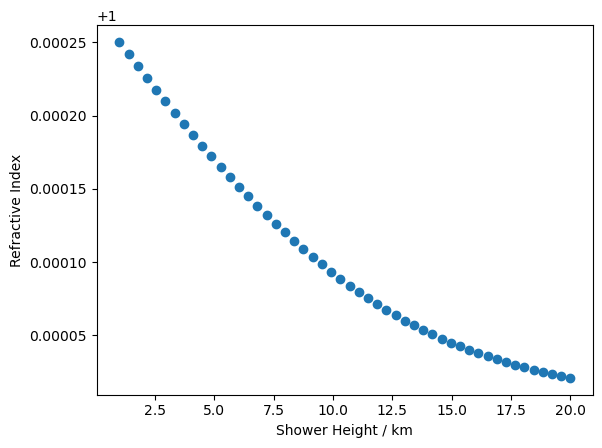

In [15]:
heights = np.linspace(1,20,50)*u.km

refrac_indices = []

# As Shower gets further into the atmosphere, atmosphere gets thicker/denser
# This causes refractive idnex to increase
for height in heights:
    refrac_indices += [calc_refractive_index(height)]

plt.plot(heights, refrac_indices, 'o')

plt.xlabel('Shower Height / km')
plt.ylabel('Refractive Index')
plt.show()

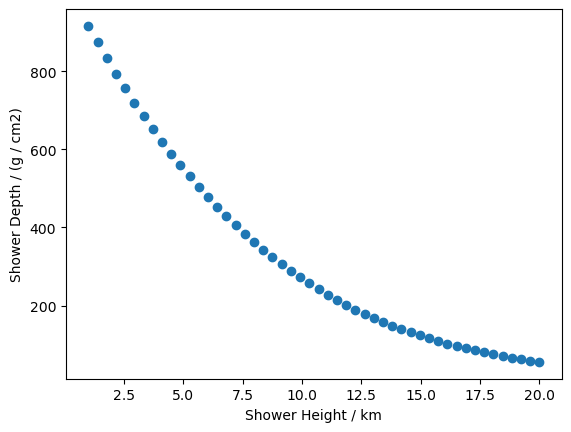

In [16]:
heights = np.linspace(1,20,50)*u.km

depths = np.array([]) * u.g / u.cm**2

# At max height, depth should be close to 0
# As shower descends, depth of shower should increase
for height in heights:
    depths = np.append(depths, convert_height_to_depth(height))

plt.plot(heights, depths, 'o')

plt.xlabel('Shower Height / km')
plt.ylabel('Shower Depth / (g / cm2)')
plt.show()

## Simulation of Charged Particles

- Energy distribution
- Angular distribution
- Positional distribution

Primary energy:  10.0 TeV
Number of charged particles:  122
Number of particles producing Cherenkov:  4 



/home/joshua_ong/anaconda3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_82692/1838290866.py:83: RuntimeWarning: invalid value encountered in power
  * (self.energy.to(u.MeV).value - 7.0) ** 0.25


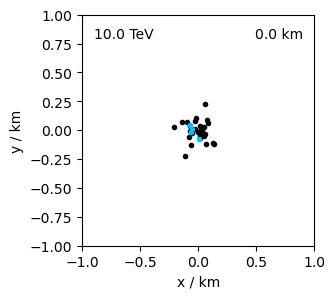

Primary energy:  10.0 TeV
Number of charged particles:  8438
Number of particles producing Cherenkov:  700 



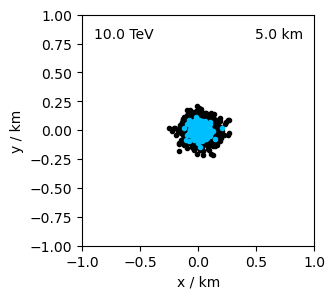

Primary energy:  10.0 TeV
Number of charged particles:  5820
Number of particles producing Cherenkov:  418 



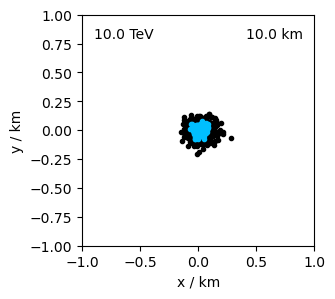

Primary energy:  10.0 TeV
Number of charged particles:  376
Number of particles producing Cherenkov:  15 



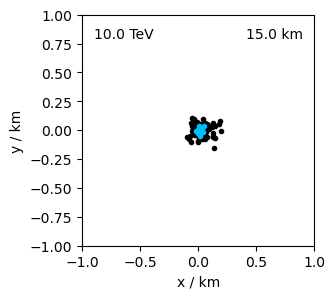

Primary energy:  10.0 TeV
Number of charged particles:  20
Number of particles producing Cherenkov:  0 



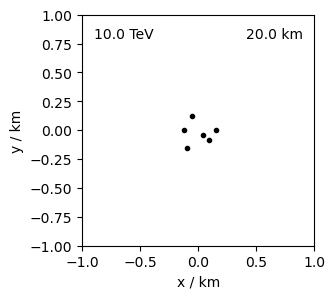

In [17]:
e_prim = 10*u.TeV
heights = np.linspace(0,20,5)*u.km

eas = ExtensiveAirShower(e_prim)

# This code shows slices of the shower at different heights with primary energy of 10TeV and how far they spread out from the primary particle
# For each height in Heights update ExtensiveAirShower parameters
for height in heights:
    eas.update_height(height)
    n = calc_refractive_index(height)
    
    p = ShowerParticle(eas)
    p.sample(remove_nonCherenkov=False)
    mask = p.beta > 1/n
    
    print('Primary energy: ', e_prim)
    print('Number of charged particles: ', eas.number_particles)
    print('Number of particles producing Cherenkov: ', np.sum(mask), '\n')
    
    plt.figure(figsize=(3,3))
    plt.plot(p.x.to(u.km)[~mask], p.y.to(u.km)[~mask], '.', color='black')
    plt.plot(p.x.to(u.km)[mask], p.y.to(u.km)[mask], '.', color='deepskyblue')
            
    plt.text(0.05, 0.9, eas.energy_primary.to(u.TeV), 
         transform=plt.gca().transAxes, horizontalalignment='left')
    plt.text(0.95, 0.9, height.to(u.km), 
         transform=plt.gca().transAxes, horizontalalignment='right')

    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('x / km')
    plt.ylabel('y / km')
    plt.show()

In [18]:
# Defines an Imaging Atmospheric Cherenkov Telescope
class IACT:

    def __init__(self):  
        self.tel_height = 2*u.km # Telescope altitude
        self.tel_depth = convert_height_to_depth(self.tel_height) # Atmospheric depth (integrated column density of air above telescope altitude)
        self.tel_pos = np.array([[0,-300]]) * u.m # Position on ground
        self.n_tel = len(self.tel_pos) # number of telescopes
        
        self.core_dist = np.sqrt( self.tel_pos[:,0]**2 + self.tel_pos[:,1]**2 ) # Distance from shower core
        self.pos_angle = np.arctan2( self.tel_pos[:,1], self.tel_pos[:,0] ) # Angle in horizontal plane)
        
        self.mirror_psf = 0.15 * u.deg # PSF
        self.mirror_radius = 6 * u.m # Mirror Radius
        self.mirror_refl = 0.2 # Reflectivity
        
        # Photomultiplier QE (average over 250->600 nm)
        self.pmt_qe = 0.3 # Quantum Efficiency (eg 30% of cherenkov photons are converted into photoelectrons)
        
    # Update telescope class
    def update(self):
        self.tel_depth = convert_height_to_depth(self.tel_height)
        self.n_tel = len(self.tel_pos)
        
        self.core_dist = np.sqrt( self.tel_pos[:,0]**2 + self.tel_pos[:,1]**2 )
        self.pos_angle = np.arctan2( self.tel_pos[:,1], self.tel_pos[:,0] )

In [19]:
# Checking default values
iact = IACT()
vars(iact)

{'tel_height': <Quantity 2. km>,
 'tel_depth': <Quantity 810.00800329 g / cm2>,
 'tel_pos': <Quantity [[   0., -300.]] m>,
 'n_tel': 1,
 'core_dist': <Quantity [300.] m>,
 'pos_angle': <Quantity [-1.57079633] rad>,
 'mirror_psf': <Quantity 0.15 deg>,
 'mirror_radius': <Quantity 6. m>,
 'mirror_refl': 0.2,
 'pmt_qe': 0.3}

In [20]:
# Simulates image produced by array of IACTs
class IACTImage:
    '''
    Input:
    - Number of telescopes
    - Position of telescopes
    - Height of telescopes
    
    Output:
    - Cherenkov Image in focal plane
    
    Functionality: 
    - create_cherenkov_image(particle): 
        creates Cherenkov image in focal plane for one particle
    - add_particle:
        calls create_cherenkov_image for the input particle, 
        and adds it to the current image
    '''
    # Initialise dataframe of photon info
    def __init__(self, iact):
        self.iact = iact
        self.omega_calculator = OmegaCalculator() # Add OmegaCalculator Instance
        self.photons = pd.DataFrame(columns=[
            'x', 
            'y', 
            'trans', 
            'long', 
            'arrival_time', 
            'cherenkov_yield', 
            'height', 
            'tel',
            'particle_id'
            ])
        
    # Convert particle position and effective emission height into angular coordinates in focal plane
    def calc_angular_position(self, px, py, eff_height):
        long = np.arctan( (self.iact.core_dist - px * np.cos(self.iact.pos_angle) - py * np.sin(self.iact.pos_angle)) / eff_height)
        trans = np.arctan( (px * np.sin(self.iact.pos_angle) - py * np.cos(self.iact.pos_angle)) / eff_height)
        
        long += np.random.normal(0, self.iact.mirror_psf.to(u.deg).value, self.iact.n_tel)*u.deg
        trans += np.random.normal(0, self.iact.mirror_psf.to(u.deg).value, self.iact.n_tel)*u.deg
        return long, trans
    
    # Turns angular coordinates into fixed cartesian coordinates in focal plane
    def calc_fixed_position(self, long, trans):
        x = long * np.cos(-self.iact.pos_angle) - trans * np.sin(-self.iact.pos_angle)
        y = long * np.sin(-self.iact.pos_angle) + trans * np.cos(-self.iact.pos_angle)
        return x,y
    
    # How much cherenkov light is transmitted through atmosphere from emission point to telescope
    def calc_transmission(self, ptheta, depth):
        if (depth < 953.0 * u.g / u.cm**2):
            delta = 1385.0 - (0.3798 * depth.value) - (0.000556 * depth.value**2)
        else:
            delta = 518.0

        transmission = np.exp( -(self.iact.tel_depth.value - depth.value) / (np.cos(ptheta) * delta))
        return transmission

    # Calculates fraction of cherenkov light ring that is intercepted by telescope mirror
    def calc_strikemirror(self, px, py, ptheta, pbeta, eff_height):
        # Determine radius of cherenkov light cone
        thetac = np.arccos(1.0 / (n * pbeta))
        rho = np.sin(thetac) * eff_height / np.cos(ptheta)
        # calculate projected distance d
        d = px + ( eff_height * np.tan(ptheta) )

        # Prepare arrays to hold delta_omega for each telescopes
        delta_omega_all = np.empty(self.iact.n_tel)
        delta_omega_all.fill(np.nan)
        cher_yield = np.full(self.iact.n_tel, np.nan)

        # Loop over each telescope
        for i in range(self.iact.n_tel):
            # Extract position of i-th telescope as tuple (x, y)
            tel_pos_i = (self.iact.tel_pos[i, 0], self.iact.tel_pos[i, 1])

            # Update OmegaCalculator for current telescope
            self.omega_calculator.update(
                cone_pos = (px, py),
                tel_pos = tel_pos_i,
                r_cone = rho,
                r_tel_core = (self.iact.core_dist[i] - self.iact.mirror_radius),
                r_tel_reach = (self.iact.core_dist[i] + self.iact.mirror_radius)
            )

            # Calculate delta_omega for current telescope
            delta_omega_all[i] = (self.omega_calculator.getOmegas() * ((np.pi)/180))

        # set cherenkov_yield to 0 for noy-physical values
        cher_yield[np.abs(delta_omega_all)<1e-10] = 0

        print(delta_omega_all)

        # total fraction of light on average that on average reaches mirror
        strikemirror = delta_omega_all * self.iact.mirror_radius / (4 * np.pi * self.iact.core_dist)
        return strikemirror, cher_yield
    
    # Calculates time delay of cherenkov photons arriving at telescope
    def calc_arrival_time(self, eff_height, depth):
        ''' Estimate time (ns) of Cherenkov photons from height h. 
        From Eq 5 & 6 of Hillas 1982b
        '''
        # Make this parameter adjustable?
        # Are other calculations true for other inclinations?
        shower_inclination = 0*u.deg 
        
        # distance from E to the ground along the inclined axis
        s = eff_height / np.cos(shower_inclination)
        
        # Empirical correction
        dt = 310*u.ns * (np.arctan(self.iact.core_dist / eff_height)/u.rad) ** 2 - 16.3 * u.ns * np.sqrt(self.iact.core_dist.to(u.m) / u.m)
        
        # vertical thickness gm/cm^2 between emission point and ground.
        g = self.iact.tel_depth - depth
        
        # Geometry
        pp = np.sqrt( (s + self.iact.core_dist * np.tan(shower_inclination)*np.cos(self.iact.pos_angle))**2 + self.iact.core_dist**2 )
        
        arrival_time = (pp - s - self.iact.core_dist * np.tan(shower_inclination) * np.cos(self.iact.pos_angle)) / LIGHT_SPEED + 0.00767 * u.ns * u.cm**2 / u.g * g * pp / eff_height - dt
        return arrival_time

    # incorporate single shower particle into the overall IACT image
    def add_particle(self, p, n, pid, height):
        eff_height = (height - self.iact.tel_height).to(u.m)
        depth = convert_height_to_depth(height)
        
        # temporary workaround, change later to use arrays in corresonding functions
        for i in range(len(p.x)):
            long, trans = self.calc_angular_position(p.x[i], p.y[i], eff_height)
            x, y = self.calc_fixed_position(long, trans)
        
            strikemirror, photons = self.calc_strikemirror(p.x[i], p.y[i], p.theta[i], p.beta[i], eff_height)
        
            transmission = self.calc_transmission(p.theta[i], depth)
        
            cher_yield = self.calc_cherenkov_yield(n, p.beta[i], height)
        
            mask = np.isnan(photons) # I don't think this can happen anymore, as we only produce beta > 1/n
            # However, if ShowerParticle.sample(remove_nonCherenkov=False) is called, it would be needed
            photons[mask] = ( cher_yield * strikemirror[mask] 
                             * transmission * self.iact.pmt_qe 
                             * self.iact.mirror_refl / (np.cos(p.theta[i])) )

            arrival_time = self.calc_arrival_time(eff_height, depth)
        
            for tel in range(self.iact.n_tel):
                if photons[tel] > 0:
                    self.photons = pd.concat([
                        self.photons,
                        pd.DataFrame([{
                        'x': x[tel].to(u.deg).value, 
                        'y': y[tel].to(u.deg).value,
                        'long': long[tel].to(u.deg).value,
                        'trans': trans[tel].to(u.deg).value,
                        'cherenkov_yield': cher_yield.value,
                        'photons': photons[tel],
                        'arrival_time': arrival_time[tel].to(u.ns).value, 
                        'height': height.to(u.km).value,
                        'tel': tel,
                        'particle_id': pid
                        }])], ignore_index=True)

    # Determnes number of cherenkov photoelectrons produced along particle's path
    def calc_cherenkov_yield(self, n, beta, height):
        '''Amount of Cerenkov photoelectrons emitted by particle over
        path interval.
        '''
        # track length in km or g/cm2 ?
        # which interval?
        track_length = ( convert_height_to_depth(height) 
                          - convert_height_to_depth(height - HEIGHT_INTERVAL) )
        #track_length = HEIGHT_INTERVAL

        # See Rowell thesis eq 2.14 pg 33.
        cherenkov_yield = 2 * np.pi * HEIGHT_INTERVAL / 137 * ( (1 / (250*u.nm)) - (1 / (650*u.nm))) * (1 - (beta * n) ** (-2))

        return cherenkov_yield.decompose()

In [21]:
print(np.arccos(2))

nan


/tmp/ipykernel_82692/2781027803.py:1: RuntimeWarning: invalid value encountered in arccos
  print(np.arccos(2))


In [22]:
iact = IACT()
#iact.tel_pos = np.array([[0,-250], [0,350], [-200,50], [200,-50]])*u.m
#iact.tel_pos = np.array([[0,-300], [0,100]])*u.m
iact.tel_pos = np.array([[0,-200], [100,200], [-100,-100]])*u.m
iact.tel_height = 0*u.km
iact.update()

e_prim = 10*u.TeV

HEIGHT_INTERVAL = 1500*u.m
upper_height = 20*u.km
lower_height = 1*u.km
heights = np.arange(lower_height.to(u.m).value, upper_height.to(u.m).value, HEIGHT_INTERVAL.to(u.m).value)*u.m

eas = ExtensiveAirShower(e_prim)

img = IACTImage(iact)
pid = 0

print("Core Distance = ", iact.core_dist)

for height in heights: 
    eas.update_height(height)
    
    n = calc_refractive_index(height)

    ps = ShowerParticle(eas)
    ps.sample()
    print(eas.number_particles, len(ps.energy))
    
    if len(ps.energy) > 0:
        img.add_particle(ps, n, pid, height)
    pid += 1

Core Distance =  [200.         223.60679775 141.42135624] m
451 38


TypeError: no implementation found for 'numpy.roots' on types that implement __array_function__: [<class 'astropy.units.quantity.Quantity'>]

In [ ]:
# Print the data of each photon
# x, y = x and y coordinate in focal plane (in degrees) corresponding to photons location for that telescope
# long = longitudinal angular coordinate in focal plane (degrees)
# trans = transverse angular coordinate in focal plane (degrees)
# arrival_time = estimated time (in ns) when cherenkov photons reach telescope
# cherenkov_yield = intrinsic number of cherenkov photoelectrons expected to be produced by particle
# height = altitude at which particle (cherenkov emission) is located
# tel = index of telescope
# parti le_id = unique identifier for shower particle (currently broken/tied to height)
# photons = number of cherenkov photons that his the mirror for each telescope
img.photons

,x,y,trans,long,arrival_time,cherenkov_yield,height,tel,particle_id,photons
0,1.836490,11.572322,-1.836490,11.572322,285.410207,23173.957806,1.0,0,0,3.397345
1,6.877461,-9.589068,1.863026,11.652417,312.031623,23173.957806,1.0,1,0,4.080417
2,1.181862,10.711629,-1.181862,10.711629,285.410207,65536.990095,1.0,0,0,5.756952
3,6.845555,-10.749376,1.315584,12.675960,312.031623,65536.990095,1.0,1,0,4.254134
4,-5.140076,6.822676,-1.189778,8.458943,221.818464,65536.990095,1.0,2,0,7.076281
...,...,...,...,...,...,...,...,...,...,...
10552,0.157515,-0.429026,-0.050981,0.454175,255.742797,6455.690121,17.5,1,11,0.049803
10553,-0.529067,0.362301,0.117922,0.630292,203.012754,6455.690121,17.5,2,11,0.072374
10554,0.449579,0.390815,-0.449579,0.390815,241.413729,3714.619831,19.0,0,12,0.035573
10555,0.374317,-0.319796,0.191782,0.453434,255.508032,3714.619831,19.0,1,12,0.031830


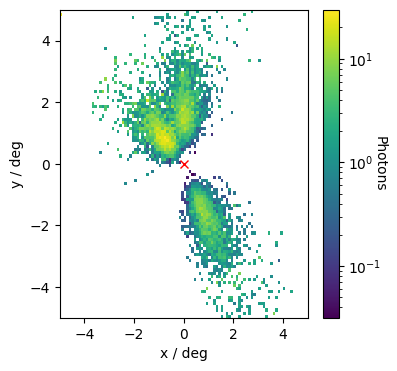

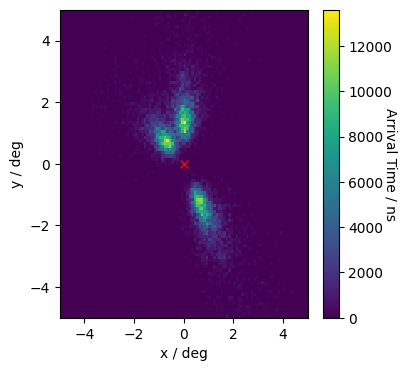

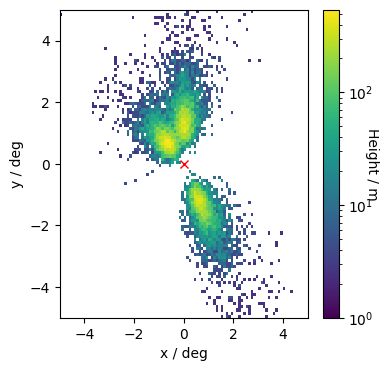

In [ ]:
# Plot 1 - Photon count distribution. Weighted by # of photons
mask = (img.photons.arrival_time>0)
plt.figure(figsize=(4,4))
plt.hist2d(img.photons.x[mask], img.photons.y[mask], weights=img.photons.photons[mask],
          bins=(100, 100), range=((-5,5),(-5,5)), norm=LogNorm(),
          )
plt.plot(0,0,'rx')

cbar = plt.colorbar()
cbar.set_label('Photons', rotation=270)
plt.xlabel('x / deg')
plt.ylabel('y / deg')
plt.show()

################
# Plot 2 - Arrival time distribution. Weighted by arrival time for each photon
mask = (img.photons.arrival_time>0)
plt.figure(figsize=(4,4))
plt.hist2d(img.photons.x[mask], img.photons.y[mask], weights=img.photons.arrival_time[mask],
          bins=(100, 100), range=((-5,5),(-5,5)), #norm=LogNorm(),
          )
plt.plot(0,0,'rx')

cbar = plt.colorbar()
cbar.set_label('Arrival Time / ns', rotation=270)
plt.xlabel('x / deg')
plt.ylabel('y / deg')
plt.show()

################
# Plot 3 - Emission height distribution. Weighted by height photons were produced
mask = (img.photons.arrival_time>0)
plt.figure(figsize=(4,4))
plt.hist2d(img.photons.x[mask], img.photons.y[mask], weights=img.photons.height[mask],
          bins=(100, 100), range=((-5,5),(-5,5)), norm=LogNorm(),
          )
plt.plot(0,0,'rx')

cbar = plt.colorbar()
cbar.set_label('Height / m', rotation=270)
plt.xlabel('x / deg')
plt.ylabel('y / deg')
plt.show()

In [ ]:
# #from ipywidgets import interact, interactive, fixed, interact_manual
# #import ipywidgets as widgets

# from ipywidgets import interact

In [ ]:
# Creates interactive visualization
@interact(time=(200,300,5))
def plot(time):
    # First plot shows spatial distribution of cherenkov photons within time window
    # Mask defined that selects only photons whose arrival time is within 2 ns window around slider value
    mask = ( (img.photons.arrival_time > time-1) & (img.photons.arrival_time < time+1) )
    plt.figure(figsize=(4,4))
    plt.hist2d(img.photons.x[mask], img.photons.y[mask], weights=img.photons.photons[mask],
              bins=(100, 100), range=((-5,5),(-5,5)), norm=LogNorm(),
              ) # Histogram weighted by # of photons, 100x100 bins over range (-5, 5) in x & y
    plt.plot(0,0,'rx') # Center of image

    plt.clim([np.min(img.photons.photons), np.max(img.photons.photons)])
    cbar = plt.colorbar()
    cbar.set_label('Photons', rotation=270)
    plt.xlabel('x / deg')
    plt.ylabel('y / deg')
    plt.show()
    
    # Second plot showing all arrival times
    plt.figure(figsize=(4,2))
    plt.hist(img.photons.arrival_time, bins=100) # Histogram of photon arrival times
    plt.xlabel('Arrival Time / ns')
    plt.show()

interactive(children=(IntSlider(value=250, description='time', max=300, min=200, step=5), Output()), _dom_clas…

In [ ]:
# Shows an interactive plot with the photon counts at different time
@interact(height=(4,20,1))
def plot(height):
    mask = ( (img.photons.height > height-1) & (img.photons.height < height+1) )
    plt.figure(figsize=(4,4))
    plt.hist2d(img.photons.x[mask], img.photons.y[mask], weights=img.photons.photons[mask],
              bins=(100, 100), range=((-5,5),(-5,5)), norm=LogNorm(),
              )
    plt.plot(0,0,'rx')

    plt.clim([np.min(img.photons.photons), np.max(img.photons.photons)])
    cbar = plt.colorbar()
    cbar.set_label('Photons', rotation=270)
    plt.xlabel('x / deg')
    plt.ylabel('y / deg')
    plt.show()

interactive(children=(IntSlider(value=12, description='height', max=20, min=4), Output()), _dom_classes=('widg…

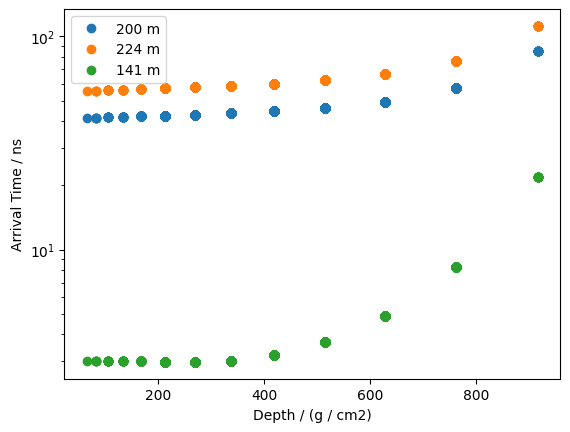

In [ ]:
# Produces scatter plot showing how arrival time of cherenkov photons varies with atmspheric depth

# Loops over each telescope, creates a boolean mask that selects photons just from that telescope's detections
# Converts heights of photons to atmospheric depths
for n in set(img.photons.tel):

    mask = (img.photons.tel == n)
    plt.plot(convert_height_to_depth(np.array(img.photons.height[mask])*u.km), 
            img.photons.arrival_time[mask] - 200, 
             'o',
            label='{:1.0f}'.format(iact.core_dist[n]))

# One telescope located aout 200m from shower core, another at 224m from core
plt.legend()
plt.xlabel('Depth / (g / cm2)')
plt.ylabel('Arrival Time / ns')
plt.yscale('log')
plt.show()

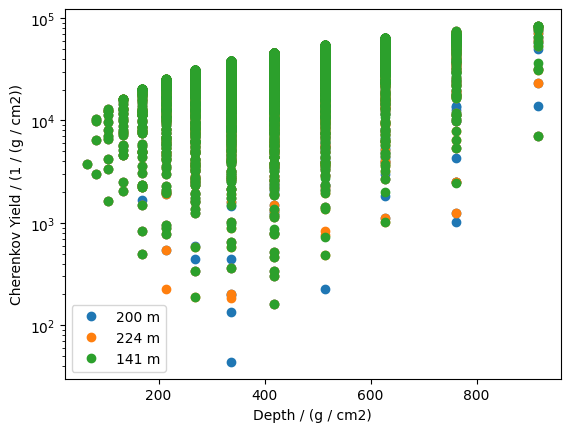

In [ ]:
# Produces scatter plot showing how timing of cherenkov light changes depending on atmospheric depth for each telescope

# Loops over each telescope
for n in set(img.photons.tel):

    mask = (img.photons.tel == n)
    plt.plot(convert_height_to_depth(np.array(img.photons.height[mask])*u.km), 
             img.photons.cherenkov_yield[mask], 'o',
            label='{:1.0f}'.format(iact.core_dist[n]) )

plt.yscale('log')
plt.xlabel('Depth / (g / cm2)')
plt.ylabel('Cherenkov Yield / (1 / (g / cm2))')
plt.legend()
plt.show()

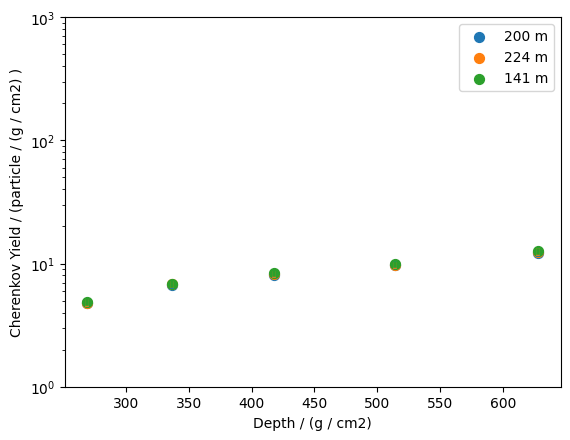

In [ ]:
# Shows the average cherenkov yield per photon

# Loops over each telescope
for n in set(img.photons.tel):

    mask = (img.photons.tel == n)
    sns.regplot(x=convert_height_to_depth(np.array(img.photons.height[mask])*u.km), 
            y=img.photons.cherenkov_yield[mask] / len(img.photons[mask]), 
            x_bins=10, fit_reg=None,
            label='{:1.0f}'.format(iact.core_dist[n]) )

plt.yscale('log')
plt.xlabel('Depth / (g / cm2)')
plt.ylabel('Cherenkov Yield / (particle / (g / cm2) )')
plt.ylim([1,1000])
plt.legend()
plt.show()

<Axes: xlabel='height', ylabel='cherenkov_yield'>

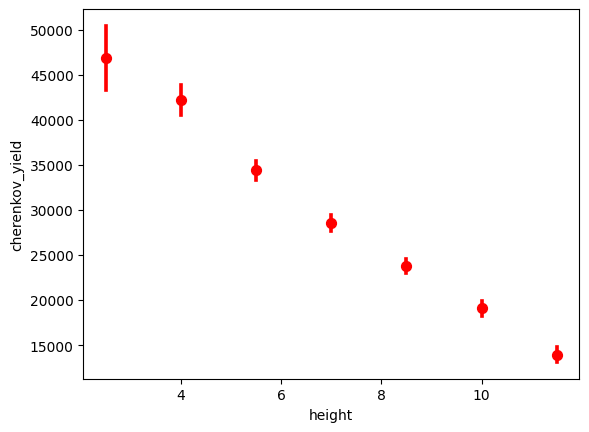

In [ ]:
# Plots the cherenkov light yield against emission height
mask = img.photons.tel == 0
sns.regplot(x=img.photons.height[mask], 
            y=img.photons.cherenkov_yield[mask], 
            x_bins=25, fit_reg=None, color='red')

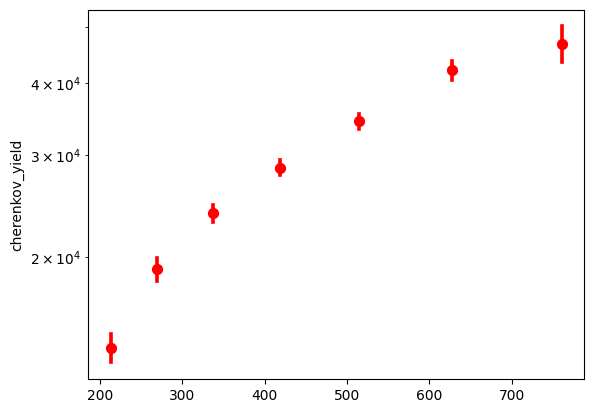

In [ ]:
# Plots the cherenkov light yield against atmospheric depth
mask = img.photons.tel == 0
sns.regplot(x=convert_height_to_depth(np.array(img.photons.height[mask])*u.km), 
            y=img.photons.cherenkov_yield[mask], 
            x_bins=25, fit_reg=None, color='red')
plt.yscale('log')

In [ ]:
# Printing photons data again
img.photons

,x,y,trans,long,arrival_time,cherenkov_yield,height,tel,particle_id,photons
0,1.836490,11.572322,-1.836490,11.572322,285.410207,23173.957806,1.0,0,0,3.397345
1,6.877461,-9.589068,1.863026,11.652417,312.031623,23173.957806,1.0,1,0,4.080417
2,1.181862,10.711629,-1.181862,10.711629,285.410207,65536.990095,1.0,0,0,5.756952
3,6.845555,-10.749376,1.315584,12.675960,312.031623,65536.990095,1.0,1,0,4.254134
4,-5.140076,6.822676,-1.189778,8.458943,221.818464,65536.990095,1.0,2,0,7.076281
...,...,...,...,...,...,...,...,...,...,...
10552,0.157515,-0.429026,-0.050981,0.454175,255.742797,6455.690121,17.5,1,11,0.049803
10553,-0.529067,0.362301,0.117922,0.630292,203.012754,6455.690121,17.5,2,11,0.072374
10554,0.449579,0.390815,-0.449579,0.390815,241.413729,3714.619831,19.0,0,12,0.035573
10555,0.374317,-0.319796,0.191782,0.453434,255.508032,3714.619831,19.0,1,12,0.031830


In [ ]:
vars(iact)

{'tel_height': <Quantity 0. km>,
 'tel_depth': <Quantity 1032.72639489 g / cm2>,
 'tel_pos': <Quantity [[   0., -200.],
            [ 100.,  200.],
            [-100., -100.]] m>,
 'n_tel': 3,
 'core_dist': <Quantity [200.        , 223.60679775, 141.42135624] m>,
 'pos_angle': <Quantity [-1.57079633,  1.10714872, -2.35619449] rad>,
 'mirror_psf': <Quantity 0.15 deg>,
 'mirror_radius': <Quantity 6. m>,
 'mirror_refl': 0.2,
 'pmt_qe': 0.3}

In [ ]:
print(len(img.photons))
print(np.sum(img.photons.CherenkovYield))
img.photons.head()

10557


AttributeError: 'DataFrame' object has no attribute 'CherenkovYield'

In [ ]:
print(e_prim.to(u.TeV))

#### Photon

- trans / long (angular position)
- x / y (position in fixed frame - for stereo)
- z (Cherenkov yield)
- st (time)

In [ ]:
e_prim = 1*u.TeV
height = 20*u.km

tel_pos = np.array([[0,-300], 
                    [0,100], 
                    [-200,-100], 
                    [200,-100]])
tel_height = 2 * u.km

cs = CherenkovShower(e_prim)
s = cs.calc_shower_age(height)
n = cs.calc_refractive_index(height)
ptotal = cs.calc_number_shower_particles(height)
gh = cs.conversion_gh(height)

ci = CherenkovImage(tel_pos)
    
for i in range(ptotal):
    p = ShowerParticle(s)
        
    if p.beta < 1/n:
        p.sample_angle()
        p.sample_position(gh)

        #ci.add_particle(p)

In [ ]:
cs = CherenkovShower(1000*u.GeV)

heights = np.linspace(1,20,50)*u.km
number_particles = []
shower_ages = []

for height in heights:
    number_particles += [cs.get_number_shower_particles(height)]
    shower_ages += [cs.get_shower_age(height)]
    
    
plt.plot(heights, number_particles, 'o')
plt.text(0.95, 0.9, cs.energy_primary.to(u.TeV), 
         transform=plt.gca().transAxes, horizontalalignment='right')
plt.xlabel('Shower Height / km')
plt.ylabel('Number of Shower Particles')
plt.show()

plt.plot(heights, shower_ages, 'o')
plt.text(0.95, 0.9, cs.energy_primary.to(u.TeV), 
         transform=plt.gca().transAxes, horizontalalignment='right')
plt.xlabel('Shower Height / km')
plt.ylabel('Shower Age')
plt.show()